In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.cluster.vq import kmeans2
import time
from gpflow import set_trainable
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

from gp4gw.sample import SampleLogJoint
import gp4gw.bbh_example as bbh_example
from gp4gw.data_preparation import *
from gp4gw.training_tools import *
from gp4gw.deep_kernel import DeepKernel

# Make plots inline
%matplotlib inline
import matplotlib
import corner
from os import path

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Point tensorflow to correct CUDA installation to use
import os
aPath = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11/'
os.environ['XLA_FLAGS'] = aPath

In [3]:
# Select only one GPU Tesla V-100
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2021-12-06 09:40:52.376963: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


# Load PE samples and prepare data
This notebook runs on a 8-D injection created on the Hawk cluster LIGO partition at `/home/virginia.demilio/GP-Project-PE/posterior_samples/production_injections/16s_prior_powerlaw/`.<br>
Data preparation is done with `scale_data` function, which applies standard `sklearn` scaling functions:<br>
* The log-likelihood data is scaled according to z-score, i.e. mean of zero and standard deviation of one (StandardScaler function)
* The posterior samples such that all dimensions are scaled between zero and one (MinMaxScaler function)

In [6]:
data_path='../posterior_samples/16s_prior_powerlaw_data0_0_analysis_H1L1V1_dynesty_result.json'

In [7]:
analytic_priors = bbh_example.priors_from_bilby_object(data_path)
param_names = bbh_example.sampled_parameters(analytic_priors)

my_data = scale_data(**bbh_example.load_data(path=data_path, param_names=param_names, samples_frac=1.0))
parameters_scaler = my_data["x_scaler"]
likelihood_scaler = my_data["y_scaler"]

Shape of x-data: N=25087, Q=8


In [8]:
my_data["x_train"].shape

(25087, 8)

In [9]:
X = tf.convert_to_tensor(my_data["x_train"], dtype=tf.float64)
Y = tf.convert_to_tensor(my_data["y_train"].reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape
print(f'X_train shape: {N}, {Q}; Y_train shape: {Y.shape}')

X_train shape: 25087, 8; Y_train shape: (25087, 1)


2021-12-06 09:40:53.587396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-06 09:40:53.589069: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


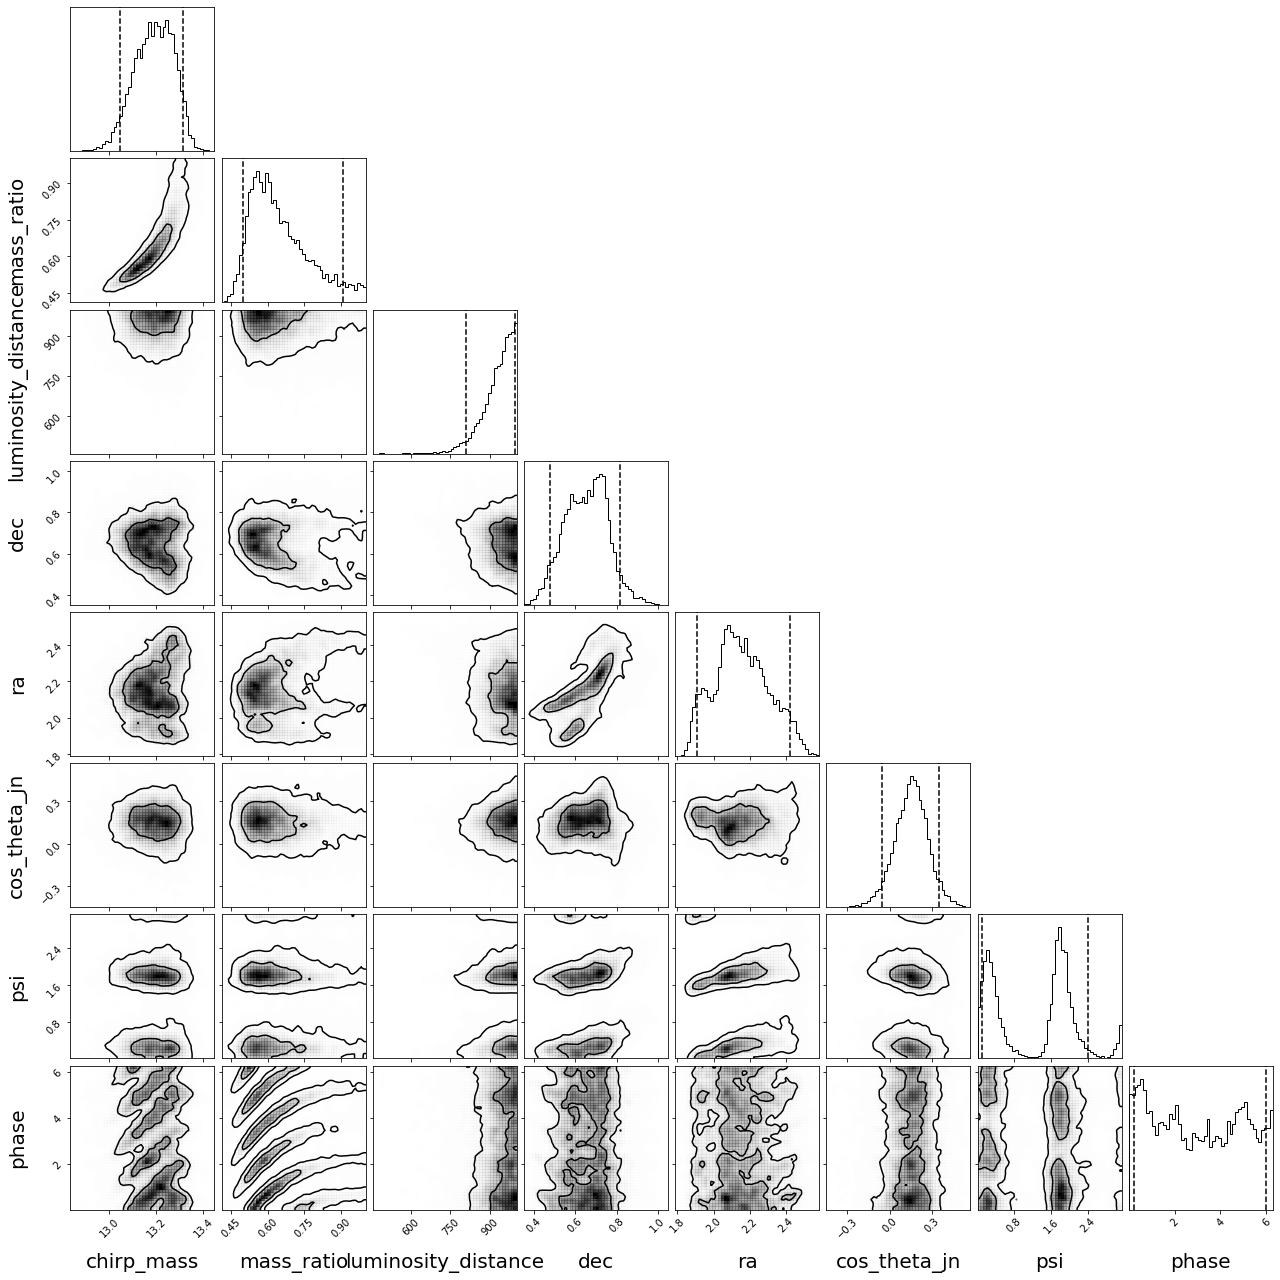

In [10]:
fig1 = corner.corner(
    parameters_scaler.inverse_transform(my_data['x_train']),
    bins=50,
    labels=param_names,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

# Build GP model

For this part use TensorFlow GPU.
The base kernel is defined here, it is then passed to the `DeepKernel` class (defined in `gp4gw`) such that X is transformed according to a non-linear mapping given by the deep architecture. See [Wilson 2016](http://proceedings.mlr.press/v51/wilson16.pdf).

In [11]:
data_dim = X.shape[1]

In [12]:
k1 = gpflow.kernels.SquaredExponential(
    active_dims=[param_names.index('chirp_mass'),
                param_names.index('mass_ratio'),
                param_names.index('luminosity_distance'),
                param_names.index('dec'),
                param_names.index('cos_theta_jn'),
                 param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales=[0.1]*data_dim , variance=1.0)

k4 = gpflow.kernels.Matern12(
    active_dims=[param_names.index('chirp_mass'),
                param_names.index('mass_ratio'),
                param_names.index('luminosity_distance'),
                param_names.index('dec'),
                param_names.index('cos_theta_jn'),
                 param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales=[1.0]*data_dim , variance=1.0)

kperiodic = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(
    active_dims=[param_names.index('psi'),
                 param_names.index('phase'),
                 param_names.index('ra')], lengthscales = 0.1, variance=1.0))

kernel = DeepKernel(
    data_dim, data_dim, k1*k4*kperiodic
)

In [13]:
M = 500 # number of inducing points

Inducing points are initialised with K-means algorithm, the RobustGP algorithm leads to **worst** results, do not waste time with it.

In [14]:
Z = kmeans2(X.numpy(), M, minit="points")[0]

# Initialise hyperparameters here
# init_method = robustgp.ConditionalVariance()
# Z = init_method.compute_initialisation(X.numpy(), M, kernel)[0]

model = gpflow.models.SGPR(
   (X, Y), kernel, inducing_variable=Z, mean_function=gpflow.mean_functions.Constant(min(Y)-10), noise_variance=1.01e-5
)

# start_time = time.time()
# for _ in range(10):
#     # Optimise w.r.t. hyperparmeters here...
#     Z = init_method.compute_initialisation(X.numpy(), M, kernel)[0]  # Reinit with the new kernel hyperparameters
#     model.inducing_variable.Z = gpflow.Parameter(Z)
# print("--- Computing inducing points took %s minutes ---" % ((time.time() - start_time) / 60))

In [15]:
# Testing prediction BEFORE training
# mean, cov = model.predict_y(X)
# plt.plot((mean - Y))
# print('Test MAE: {}'.format(np.mean(np.abs(mean - Y))))

Setting trainable equals to False for the mean function leads to **worst** results, do not waste time with it.

In [16]:
set_trainable(model.mean_function, True)

2021-12-06 09:40:58.301557: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [17]:
adam_learning_rate=0.1
lr_schedule=True

In [18]:
nepochs=50

In [19]:
if lr_schedule:
    lr = InverseTimeDecay(
        adam_learning_rate,
        decay_steps=int(nepochs / 4),
        decay_rate=1,
        staircase=False)
else:
    lr = adam_learning_rate

start_time = time.time()
model_logdir = "../models/model_8D_M500_N50_128_128_128/"
step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
epoch_var = tf.Variable(1, dtype=tf.int32, trainable=False)
ckpt = tf.train.Checkpoint(model=model, step=step_var, epoch=epoch_var)
manager = tf.train.CheckpointManager(ckpt, model_logdir, max_to_keep=5)
if path.exists(model_logdir + "checkpoint"):
    print(f"Loading model from folder path {model_logdir}")
    ckpt.restore(manager.latest_checkpoint)
else:
    print(f"Checkpoint folder path at: {model_logdir}")
    checkpointing_training_loop_exact_GP(
        model,
        X = X,
        Y = Y,
        optimizer=tf.keras.optimizers.Adam(lr),
        epochs=nepochs,
        manager=manager,
        epoch_var=epoch_var)
    print("--- Training took %s minutes ---" % ((time.time() - start_time) / 60))
    
# This training loop doesn't save the model, which will be lost when changing kernel for inference.
# Only use when testing the Kernel architecture, i.e. only looking at the MSE on the model.
# only_training_loop_exact_GP(
#     model,
#     X = X,
#     Y = Y,
#     optimizer=tf.keras.optimizers.Adam(lr),
#     epochs=nepochs
# )
print(
    f"Training error: {mean_squared_error(Y, model.predict_y(X)[0])}"
)

Loading model from folder path ../models/model_8D_M500_N50_128_128_128/
Training error: 0.15247583056697336


19.99min training time on CPU on Hawk LIGO partition

# Assessing model accuracy

In [20]:
mean, cov = model.predict_y(X)

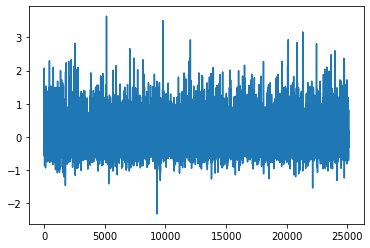

In [21]:
plt.plot((mean - Y))

In [22]:
print('Test MAE: {}'.format(np.mean(np.abs(mean - Y))))

Test MAE: 0.28352606009799775


# Sample GP model

Change kernel to use TensorFlow on CPU.
The inference on GPU would take O(30) minutes otherwise.

In [23]:
X_scaled = my_data['x_scaler'].inverse_transform(my_data['x_train'])

In [24]:
mcmc_points = 8000
num_chains = 10
num_burnin = mcmc_points * 0.3
initialise_chains = np.mean(X, axis=0)

In [25]:
quick_priors = bbh_example.quick_priors(X_scaled, param_names, analytic_priors)

Loading non-scaled priors bounds


In [26]:
sample = SampleLogJoint(
    predict_log_joint_mean_var=model.predict_f,
    analytic_priors=quick_priors,
    param_names=param_names,
    parameters_scaler=my_data['x_scaler'],
    log_joint_scaler=my_data['y_scaler'],
)

In [27]:
print(f'mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}')
start_time = time.time()
print("Running chain..")
all_samples = sample.run_chain(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=initialise_chains + 1e-3 * np.random.randn(num_chains, X.shape[1]),
    num_chains=num_chains,
    sampler='HMC',
)
print("--- Sampling took %s minutes ---" % ((time.time() - start_time) / 60))

mcmc_points: 8000, num_burnin: 2400
Running chain..
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with SimpleStepSizeAdaptation


2021-12-06 09:41:08.826255: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700000000 Hz
2021-12-06 09:41:08.827601: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c6ac75c4d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-06 09:41:08.827662: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-06 09:41:09.056926: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:241] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired.
2021-12-06 09:41:26.931736: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


--- Sampling took 9.467827451229095 minutes ---


17.16min sampling time on CPUs on Hawk LIGO partition

In [28]:
combine_chains = np.zeros((mcmc_points * num_chains, len(param_names)))
for i in range(len(param_names)):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = my_data['x_scaler'].inverse_transform(combine_chains)

In [29]:
az_data = convert_to_arviz_data(all_samples, my_data['x_scaler'], param_names)

In [30]:
print(az.summary(az_data)['r_hat'])

chirp_mass             1.05
mass_ratio             1.05
luminosity_distance    1.01
dec                    1.05
ra                     1.15
cos_theta_jn           1.03
psi                    1.32
phase                  1.09
Name: r_hat, dtype: float64


In [31]:
latex_names = {
    'chirp_mass': r'$\mathcal{M}$',
    'mass_ratio': r'q',
    'a_1': r'$a_1$',
    'a_2': r'$a_2$',
    'luminosity_distance': r'$d_{L}$',
    'phase': r'$\phi$',
    'psi': r'$\psi$',
    'dec': r'dec',
    'ra': r'ra',
    'cos_theta_jn': r'$cos(\theta_{jn})$'
              }

In [ ]:
blue_line = matplotlib.lines.Line2D([], [], color="k", label="PE samples")
red_line = matplotlib.lines.Line2D([], [], color="darkorange", label="GP samples")
fig1 = corner.corner(
    parameters_scaler.inverse_transform(my_data['x_train']),
    bins=50,
    labels=[latex_names[key] for key in param_names],
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    labels=[latex_names[key] for key in param_names],
    color="darkorange",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig.get_axes()[4].tick_params(which="major", bottom=False)
fig.get_axes()[5].tick_params(which="both", bottom=False)
fig.get_axes()[8].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", left=False)
fig.get_axes()[10].tick_params(which="both", bottom=False)
fig.get_axes()[13].tick_params(which="both", left=False)
fig.get_axes()[14].tick_params(which="both", left=False)
fig.get_axes()[0].tick_params(which="both", bottom=False)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)

plt.legend(
    handles=[blue_line, red_line],
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc=4,
    fontsize=15,
)

# plt.savefig("GP_likelihood_8D_ProdK_kpsi_kphase_kra.png")